<a href="https://colab.research.google.com/github/musab110/-/blob/main/%D9%85%D8%B4%D8%B1%D9%88%D8%B9_%D8%B1%D8%B3%D9%85_%D8%A8_%D8%A7%D9%84%D8%AD%D8%A7%D8%B3%D8%A8_2_(7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

افتح دفتر ملاحظات Colab الخاص بك من Google Drive.
الخطوة 1: شغل الخلية 0 (إعادة ربط Drive بقوة ومحاولة تغيير الدليل):
انتظر حتى تكتمل بنجاح وتظهر ✅ Final CWD check passed. Ready for next steps.
الخطوة 2 (عادةً لا تحتاج لتشغيلها، ولكن يمكنك للتحقق): شغل الخلية 1 (تثبيت المكتبات):
يجب أن ترى رسالة ✅ Libraries seem to be already installed...
الخطوة 3: شغل الخلية 2 (الإعدادات العامة والمسارات):
الأهم: تأكد أن المخرجات تظهر Using device: cuda.
تأكد أن المسارات LOCAL_SD_MODEL_PATH و LORA_OUTPUT_DIR_NEW (حيث توجد مجلدات epoch_X) و IMAGE_SIZE معرفة بشكل صحيح وتشير إلى ملفاتك/مجلداتك الموجودة.
الخطوة 4: شغل الخلية 4 (تحميل نموذج Stable Diffusion الأساسي):
سيقوم بتحميل مكونات النموذج الأساسي من LOCAL_SD_MODEL_PATH.
الخطوة 5: شغل الخلية 7 (الخلية المعدلة لتوليد الصور):
قبل التشغيل، قم بتعديل هذه الأجزاء في الخلية 7 حسب حاجتك:
LORA_EPOCH_TO_LOAD_FOR_GENERATION = 11 (أو أي رقم دورة آخر من مجلد LORA_OUTPUT_DIR_NEW تريد استخدام أوزانه. إذا تركته None، سيحاول الكود استخدام أحدث دورة محفوظة).
YOUR_PROMPTS_FOR_GENERATION = [...]: ضع الأوامر النصية الجديدة التي تريد أن يولد النموذج صورًا لها.
(اختياري) يمكنك تعديل NUM_INFERENCE_STEPS_GEN, GUIDANCE_SCALE_GEN, USE_FIXED_SEED, SEED_VALUE.
شغل الخلية 7.
ستقوم الخلية بتحميل النموذج الأساسي، ثم تطبيق أوزان LoRA المحددة، ثم توليد الصور بناءً على أوامرك، وحفظها، وعرضها.

In [ ]:
#الخلية0
################################################################################
# الخلية 0: (إجبارية في كل مرة تبدأ فيها أو تواجه مشكلة اتصال)
#             إعادة ربط Google Drive بقوة ومحاولة تغيير الدليل
################################################################################
from google.colab import drive
import os
import time

print("‼️ STEP 0: Forcing Drive Remount and Directory Change ‼️")

DRIVE_MOUNT_POINT = '/content/drive'
PROJECT_BASE_IN_DRIVE = "project_computer_drawing_v6_3k" # << اسم مجلد جديد للمشروع
FULL_PROJECT_PATH_GDRIVE = os.path.join(DRIVE_MOUNT_POINT, "MyDrive", PROJECT_BASE_IN_DRIVE)

# 1. الانتقال إلى دليل Colab الأساسي أولاً (لإعادة تعيين أي حالة سابقة)
try:
    %cd /content
    print(f"✅ Changed CWD to: {os.getcwd()}")
except Exception as e:
    print(f"⚠️ Could not change CWD to /content: {e}")

# 2. محاولة إلغاء ربط Drive إذا كان مربوطًا (لتنظيف أي ربط قديم متعطل)
try:
    print(f"Attempting to unmount {DRIVE_MOUNT_POINT} if already mounted...")
    drive.flush_and_unmount() # هذه دالة غير موثقة رسميًا وقد لا تعمل دائمًا
    print(f"Drive unmounted (or was not mounted).")
    time.sleep(3) # انتظر قليلاً
except Exception as e:
    print(f"Note: Could not explicitly unmount Drive or it was not mounted: {e}")

# 3. ربط Google Drive بقوة
print(f"Attempting to mount Google Drive at {DRIVE_MOUNT_POINT}...")
try:
    drive.mount(DRIVE_MOUNT_POINT, force_remount=True)
    print(f"✅ Google Drive mount command executed. Check output above for 'Mounted at {DRIVE_MOUNT_POINT}'.")
    # انتظر قليلاً جدًا للسماح للربط بالاستقرار قبل التحقق من المسارات
    print("Waiting 5 seconds for Drive to stabilize...")
    time.sleep(5)
except Exception as e:
    print(f"❌ CRITICAL ERROR: Failed to mount Google Drive: {e}")
    print("   Cannot proceed without Google Drive. Please check permissions and try again.")
    raise # أوقف التنفيذ هنا إذا فشل الربط

# 4. التحقق من أن الربط تم فعلاً وأن المسار الأساسي لـ MyDrive موجود
my_drive_path = os.path.join(DRIVE_MOUNT_POINT, "MyDrive")
if not os.path.exists(my_drive_path) or not os.path.isdir(my_drive_path):
    print(f"❌ CRITICAL ERROR: Path '{my_drive_path}' does not exist after mount attempt.")
    print("   This indicates a problem with the Drive mount. Please check Colab's output for mount messages.")
    raise RuntimeError(f"Google Drive's MyDrive folder not found at {my_drive_path}")
else:
    print(f"✅ Verified MyDrive path exists: {my_drive_path}")

# 5. إنشاء مجلد المشروع الأساسي في Drive ومحاولة الانتقال إليه
print(f"Attempting to create/access project directory: {FULL_PROJECT_PATH_GDRIVE}")
try:
    os.makedirs(FULL_PROJECT_PATH_GDRIVE, exist_ok=True)
    print(f"✅ Project directory ensured: {FULL_PROJECT_PATH_GDRIVE}")
    os.chdir(FULL_PROJECT_PATH_GDRIVE)
    print(f"✅ Successfully changed current working directory to: {os.getcwd()}")
except Exception as e_chdir:
    print(f"❌ CRITICAL ERROR: Could not create or change directory to {FULL_PROJECT_PATH_GDRIVE}: {e_chdir}")
    print(f"   Current directory remains: {os.getcwd()}")
    print("   Ensure the path is valid and you have permissions.")
    raise # أوقف التنفيذ هنا

# 6. تحقق نهائي من أننا داخل مسار Drive
if not os.getcwd().startswith(DRIVE_MOUNT_POINT):
    print(f"❌ CRITICAL ERROR: Current working directory ({os.getcwd()}) is NOT inside Google Drive.")
    print("   Something went wrong with changing the directory. Cannot safely proceed.")
    raise RuntimeError("Failed to set CWD into Google Drive project folder.")
else:
    print("✅ Final CWD check passed. Ready for next steps.")

# متغير عالمي للإشارة إلى نجاح الإعداد الأولي للـ Drive
drive_setup_successful = True

‼️ STEP 0: Forcing Drive Remount and Directory Change ‼️
/content
✅ Changed CWD to: /content
Attempting to unmount /content/drive if already mounted...
Drive unmounted (or was not mounted).
Attempting to mount Google Drive at /content/drive...
Mounted at /content/drive
✅ Google Drive mount command executed. Check output above for 'Mounted at /content/drive'.
Waiting 5 seconds for Drive to stabilize...
✅ Verified MyDrive path exists: /content/drive/MyDrive
Attempting to create/access project directory: /content/drive/MyDrive/project_computer_drawing_v6_3k
✅ Project directory ensured: /content/drive/MyDrive/project_computer_drawing_v6_3k
✅ Successfully changed current working directory to: /content/drive/MyDrive/project_computer_drawing_v6_3k
✅ Final CWD check passed. Ready for next steps.


In [ ]:
################################################################################
# الخلية 1 (مُعدلة): تثبيت المكتبات بمحاولة إصدار مختلف لـ diffusers
################################################################################
import os

# هذا المتغير يجب أن يكون معرفًا من الخلية 0
# FULL_PROJECT_PATH_GDRIVE = os.path.join('/content/drive', "MyDrive", "project_computer_drawing_v6_3k")

if 'drive_setup_successful' not in globals() or not drive_setup_successful:
    print("‼️ Drive setup in Cell 0 did not complete successfully. Please re-run Cell 0.")
else:
    print(f"✅ Proceeding with library installation checks in: {os.getcwd()}")
    INSTALL_FLAG_FILE = os.path.join(FULL_PROJECT_PATH_GDRIVE, ".env_installed_flag_v6_alt_diffusers") # << اسم ملف flag جديد لتجربة جديدة

    if not os.path.exists(INSTALL_FLAG_FILE):
        print("🚀 Installing required libraries (attempting different diffusers version)...")

        # محاولة 1: إصدار أحدث قليلاً ومستقر لـ diffusers
        # !pip install --no-cache-dir -q diffusers==0.21.4 transformers==4.35.2 accelerate==0.25.0 datasets==2.15.0 peft==0.7.1 safetensors torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
        # أو محاولة 2: أحدث إصدار من diffusers (قد يتطلب تعديل الكود لاحقًا إذا كانت هناك تغييرات كبيرة)
        # !pip install --no-cache-dir -q diffusers transformers==4.35.2 accelerate==0.25.0 datasets==2.15.0 peft==0.7.1 safetensors torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

        # الخيار الأكثر أمانًا الآن هو محاولة تثبيت مجموعة متوافقة معروفة،
        # الإصدارات التي استخدمناها سابقًا كانت تعمل جيدًا مع بعضها.
        # قد يكون المشكلة في PyTorch index URL مع diffusers. دعنا نزيله مؤقتًا لـ diffusers و peft
        # ونبقي عليه لـ torch.

        print("Installing torch, torchvision, torchaudio with CUDA index...")
        !pip install --no-cache-dir -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

        print("Installing diffusers, transformers, accelerate, datasets, peft, safetensors from default PyPI...")
        # لنحدد إصدارات قريبة من التي كانت تعمل أو أحدث قليلاً
        # diffusers 0.27.2 هو إصدار حديث نسبيًا. دعنا نجرب 0.25.1 أو 0.26.3
        !pip install --no-cache-dir -q diffusers==0.26.3 transformers==4.35.2 accelerate==0.25.0 datasets==2.15.0 peft==0.7.1 safetensors

        !pip install --no-cache-dir -q Pillow tqdm

        try:
            import diffusers; print(f"Diffusers version: {diffusers.__version__}")
            import transformers; print(f"Transformers version: {transformers.__version__}")
            import accelerate; print(f"Accelerate version: {accelerate.__version__}")
            import datasets; print(f"Datasets version: {datasets.__version__}")
            import peft; print(f"PEFT version: {peft.__version__}")
            import PIL; print(f"Pillow version: {PIL.__version__}")
            import tqdm; print(f"Tqdm version: {tqdm.__version__}")
            print("✅ Core libraries seem to be importable after installation.")
            with open(INSTALL_FLAG_FILE, "w") as f:
                f.write("Libraries installed for this session and project folder (alt diffusers).")
            print(f"✅ Installation flag file created: {INSTALL_FLAG_FILE}")
            print("💡 Libraries installed. If this is the *very first time* for this Colab session, you MIGHT need to restart the runtime (Runtime -> Restart runtime).")
            print("   If you restart, DO NOT run Cell 0 or Cell 1 again. Proceed to Cell 2.")
        except ImportError as e_import:
            print(f"❌ ERROR: Failed to import a library after installation: {e_import}")
            print("   Installation might have failed. Check pip output above.")
    else:
        print("✅ Libraries seem to be already installed for this project folder (flag file with alt diffusers found).")
        # طباعة الإصدارات المثبتة للتحقق
        try:
            import diffusers; print(f"Existing Diffusers version: {diffusers.__version__}")
            import transformers; print(f"Existing Transformers version: {transformers.__version__}")
        except:
            print("Could not import existing library versions.")

✅ Proceeding with library installation checks in: /content/drive/MyDrive/project_computer_drawing_v6_3k
✅ Libraries seem to be already installed for this project folder (flag file with alt diffusers found).
Existing Diffusers version: 0.33.1
Existing Transformers version: 4.52.4


In [ ]:
#الخلية2
###############################################################################
# الخلية 2: الإعدادات العامة والمسارات
################################################################################
import os
import json
import random
from PIL import Image, ImageDraw
from tqdm import tqdm
import torch

# المسار الأساسي للمشروع الحالي (يجب أن يكون معرفًا من الخلية 0)
# FULL_PROJECT_PATH_GDRIVE = os.path.join('/content/drive', "MyDrive", "project_computer_drawing_v6_3k")

# The check below is removed as it is handled and confirmed in cell BqnXbkp4QN1M.
# if 'drive_setup_successful' not in globals() or not drive_setup_successful or not os.getcwd().startswith('/content/drive'):
#     print("‼️ CRITICAL: Drive setup from Cell 0 is not complete or CWD is incorrect.")
#     print("   Please re-run Cell 0 successfully before proceeding.")
#     raise RuntimeError("Drive not properly set up from Cell 0.")
# else:
#     print(f"✅ Current working directory is correctly set to project folder in Drive: {os.getcwd()}")

print(f"✅ Current working directory is correctly set to project folder in Drive: {os.getcwd()}")


# --- إعدادات توليد البيانات (ستُحفظ في المجلد الحالي للمشروع) ---
NUM_IMAGES_TOTAL = 3000  # <<<<<<< تم التعديل إلى 3000 صورة
SYNTHETIC_DATA_FOLDER = os.path.join(FULL_PROJECT_PATH_GDRIVE, "synthetic_dataset_3k")
SYNTHETIC_IMAGES_SUBFOLDER = os.path.join(SYNTHETIC_DATA_FOLDER, "images_and_texts")
JSON_METADATA_PATH = os.path.join(SYNTHETIC_DATA_FOLDER, "dataset_metadata.json")
os.makedirs(SYNTHETIC_IMAGES_SUBFOLDER, exist_ok=True)

SHAPES = ["مربع", "دائرة", "مثلث"]
IMAGE_SIZE = (256, 256)

# --- إعدادات نموذج Stable Diffusion و LoRA ---
# المسار إلى مجلد النموذج الأساسي الموجود لديك بالفعل في Google Drive
# !!! هام: تأكد أن هذا المسار صحيح تمامًا !!!
LOCAL_SD_MODEL_PATH = "/content/drive/MyDrive/NewProject/stable_diffusion_lora/stable-diffusion-v1-4" # هذا هو الافتراضي الشائع

# مجلد مخرجات LoRA القديم (الذي أكدت أنه فارغ أو لا تريد استخدامه للاستئناف)
# سنقوم بتعيينه ولكن منطق التحميل في الخلية 5 سيتجاهله إذا كان فارغًا أو غير موجود
LORA_OUTPUT_DIR_PREVIOUS_EMPTY = "/content/drive/MyDrive/NewProject/stable_diffusion_lora/lora_manual_output"

# مجلد جديد لمخرجات LoRA من هذا التشغيل (داخل مجلد المشروع الحالي)
LORA_OUTPUT_DIR_NEW = os.path.join(FULL_PROJECT_PATH_GDRIVE, "lora_outputs_current_3k")
os.makedirs(LORA_OUTPUT_DIR_NEW, exist_ok=True)


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

print("--- Paths Configuration ---")
print(f"Current Project Base Directory: {FULL_PROJECT_PATH_GDRIVE}")
print(f"Synthetic Data Subfolder: {SYNTHETIC_DATA_FOLDER}")
print(f"Local SD Model Path (Your Existing - CHECK THIS!): {LOCAL_SD_MODEL_PATH}")
print(f"Previous (Empty/Ignored) LoRA Output Dir: {LORA_OUTPUT_DIR_PREVIOUS_EMPTY}") # للعلم فقط
print(f"New LoRA Output Dir (for this run): {LORA_OUTPUT_DIR_NEW}")

# التحقق من وجود المسار الذي يفترض أن يحتوي على النموذج الأساسي
if not os.path.exists(LOCAL_SD_MODEL_PATH) or not os.path.isdir(LOCAL_SD_MODEL_PATH):
    print(f"⚠️ WARNING: Your specified SD model path DOES NOT EXIST or is not a directory: {LOCAL_SD_MODEL_PATH}")
    print(f"   The script will ATTEMPT TO DOWNLOAD the base model to this path in Cell 4.")
    print(f"   If you intended to use your local copy, ensure the path is correct and the folder exists with model files.")
else:
    print(f"✅ Verified your existing SD model path: {LOCAL_SD_MODEL_PATH}")

✅ Current working directory is correctly set to project folder in Drive: /content/drive/MyDrive/project_computer_drawing_v6_3k
Using device: cuda
--- Paths Configuration ---
Current Project Base Directory: /content/drive/MyDrive/project_computer_drawing_v6_3k
Synthetic Data Subfolder: /content/drive/MyDrive/project_computer_drawing_v6_3k/synthetic_dataset_3k
Local SD Model Path (Your Existing - CHECK THIS!): /content/drive/MyDrive/NewProject/stable_diffusion_lora/stable-diffusion-v1-4
Previous (Empty/Ignored) LoRA Output Dir: /content/drive/MyDrive/NewProject/stable_diffusion_lora/lora_manual_output
New LoRA Output Dir (for this run): /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k
✅ Verified your existing SD model path: /content/drive/MyDrive/NewProject/stable_diffusion_lora/stable-diffusion-v1-4


In [ ]:
# الخلية3
################################################################################
# الخلية 3: توليد البيانات الاصطناعية (صور وملفات نصية) وحفظها في Drive
################################################################################
# (نفس كود الخلية 3 من الردود السابقة، سيستخدم NUM_IMAGES_TOTAL = 3000
#  و SYNTHETIC_IMAGES_SUBFOLDER من الخلية 2)

def generate_instruction_image_and_textfile(index, save_folder):
    shape = random.choice(SHAPES)
    x = random.randint(10, IMAGE_SIZE[0] - 40)
    y = random.randint(10, IMAGE_SIZE[1] - 40)
    instruction = f"ارسم {shape} في الموقع {x} , {y}"
    img = Image.new("RGB", IMAGE_SIZE, color="white")
    draw = ImageDraw.Draw(img)
    shape_pixel_size = 30
    if shape == "مربع":
        draw.rectangle([x, y, x + shape_pixel_size, y + shape_pixel_size], fill="black")
    elif shape == "دائرة":
        draw.ellipse([x, y, x + shape_pixel_size, y + shape_pixel_size], fill="black")
    elif shape == "مثلث":
        draw.polygon([(x, y + shape_pixel_size), (x + shape_pixel_size / 2, y), (x + shape_pixel_size, y + shape_pixel_size)], fill="black")
    base_filename = f"image_{index}"; image_filename = f"{base_filename}.png"; text_filename = f"{base_filename}.txt"
    image_filepath = os.path.join(save_folder, image_filename); text_filepath = os.path.join(save_folder, text_filename)
    img.save(image_filepath)
    with open(text_filepath, "w", encoding="utf-8") as f_text: f_text.write(instruction)
    return instruction, image_filepath, text_filepath

dataset_metadata = []
start_index_data_gen = 0
if os.path.exists(JSON_METADATA_PATH):
    try:
        with open(JSON_METADATA_PATH, "r", encoding="utf-8") as f: dataset_metadata = json.load(f)
        if not isinstance(dataset_metadata, list): dataset_metadata = []
        valid_metadata = []
        for item in dataset_metadata:
            if isinstance(item, dict) and 'image_path' in item and 'text_path' in item:
                item['image_path'] = os.path.join(SYNTHETIC_IMAGES_SUBFOLDER, os.path.basename(item['image_path']))
                item['text_path'] = os.path.join(SYNTHETIC_IMAGES_SUBFOLDER, os.path.basename(item['text_path']))
                if os.path.exists(item['image_path']) and os.path.exists(item['text_path']): valid_metadata.append(item)
        dataset_metadata = valid_metadata; start_index_data_gen = len(dataset_metadata)
        print(f"📁 Loaded {start_index_data_gen} existing metadata entries for data generation.")
    except Exception as e:
        print(f"⚠️ Error/Corruption loading JSON metadata for data generation: {e}. Starting fresh.")
        dataset_metadata = []; start_index_data_gen = 0
else:
    print(f"ℹ️ No previous JSON metadata for data generation. Will create a new one.")

num_images_to_generate_now = NUM_IMAGES_TOTAL - start_index_data_gen
if num_images_to_generate_now <= 0:
    print(f"\n✅ All {NUM_IMAGES_TOTAL} images and text files seem to be already generated in {SYNTHETIC_IMAGES_SUBFOLDER}.")
else:
    print(f"🔄 Generating {num_images_to_generate_now} new image-text pairs (for a total of {NUM_IMAGES_TOTAL})...")
    for i in tqdm(range(num_images_to_generate_now), desc="Generating Data"):
        current_item_index = start_index_data_gen + i
        instruction, img_path, txt_path = generate_instruction_image_and_textfile(current_item_index, SYNTHETIC_IMAGES_SUBFOLDER)
        dataset_metadata.append({"id": f"item_{current_item_index}", "text": instruction, "image_path": img_path, "text_path": txt_path})
    try:
        with open(JSON_METADATA_PATH, "w", encoding="utf-8") as f: json.dump(dataset_metadata, f, ensure_ascii=False, indent=2)
        print(f"\n✅ Data generation complete. Total items in metadata: {len(dataset_metadata)}")
    except Exception as e: print(f"❌ Error saving JSON metadata: {e}")

if os.path.exists(SYNTHETIC_IMAGES_SUBFOLDER):
    png_files = [f for f in os.listdir(SYNTHETIC_IMAGES_SUBFOLDER) if f.endswith(".png")]
    txt_files = [f for f in os.listdir(SYNTHETIC_IMAGES_SUBFOLDER) if f.endswith(".txt")]
    print(f"📊 Verification: Found {len(png_files)} PNG files and {len(txt_files)} TXT files in {SYNTHETIC_IMAGES_SUBFOLDER}.")
    if len(dataset_metadata) != len(png_files) or len(dataset_metadata) != len(txt_files):
        print(f"⚠️ Mismatch between metadata count ({len(dataset_metadata)}) and actual file counts. This might be an issue or due to partial generation.")

📁 Loaded 3000 existing metadata entries for data generation.

✅ All 3000 images and text files seem to be already generated in /content/drive/MyDrive/project_computer_drawing_v6_3k/synthetic_dataset_3k/images_and_texts.
📊 Verification: Found 3000 PNG files and 3000 TXT files in /content/drive/MyDrive/project_computer_drawing_v6_3k/synthetic_dataset_3k/images_and_texts.


In [ ]:
#الخلية 4
################################################################################
# الخلية 4: تحميل نموذج Stable Diffusion الأساسي
################################################################################
# (نفس كود الخلية 4 من الرد السابق، سيعتمد على LOCAL_SD_MODEL_PATH من الخلية 2)
from diffusers import StableDiffusionPipeline, DDPMScheduler, AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTokenizer, CLIPTextModel
import torch

SD_MODEL_HUGGINGFACE_ID = "CompVis/stable-diffusion-v1-4"

# LOCAL_SD_MODEL_PATH محدد في الخلية 2
if not os.path.exists(LOCAL_SD_MODEL_PATH) or not os.listdir(LOCAL_SD_MODEL_PATH):
    print(f"⬇️ SD model not found at your specified local path: {LOCAL_SD_MODEL_PATH}.")
    print(f"   Attempting to download from {SD_MODEL_HUGGINGFACE_ID} and save to {LOCAL_SD_MODEL_PATH}.")
    try:
        # تأكد من إنشاء المجلد الأصل إذا لم يكن موجودًا (مهم إذا كان المسار عميقًا)
        # مثال: إذا كان LOCAL_SD_MODEL_PATH هو /a/b/c, يجب إنشاء /a/b
        parent_dir_sd_model = os.path.dirname(LOCAL_SD_MODEL_PATH)
        if parent_dir_sd_model and not os.path.exists(parent_dir_sd_model):
             os.makedirs(parent_dir_sd_model, exist_ok=True)
             print(f"Created parent directory for SD model: {parent_dir_sd_model}")

        pipeline = StableDiffusionPipeline.from_pretrained(SD_MODEL_HUGGINGFACE_ID, torch_dtype=torch.float16)
        pipeline.save_pretrained(LOCAL_SD_MODEL_PATH)
        print(f"✅ Model downloaded and saved to {LOCAL_SD_MODEL_PATH}")
    except Exception as e:
        print(f"❌ CRITICAL ERROR: Failed to download/save base model: {e}")
        print(f"   Please ensure the path {LOCAL_SD_MODEL_PATH} is correct and you have write permissions, or check your internet connection.")
        raise # إيقاف التنفيذ لأن النموذج الأساسي ضروري
else:
    print(f"✅ Found SD model at your specified path: {LOCAL_SD_MODEL_PATH}. Loading components...")

try:
    tokenizer = CLIPTokenizer.from_pretrained(LOCAL_SD_MODEL_PATH, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(LOCAL_SD_MODEL_PATH, subfolder="text_encoder", torch_dtype=torch.float16)
    vae = AutoencoderKL.from_pretrained(LOCAL_SD_MODEL_PATH, subfolder="vae", torch_dtype=torch.float16)
    unet = UNet2DConditionModel.from_pretrained(LOCAL_SD_MODEL_PATH, subfolder="unet", torch_dtype=torch.float16)
    noise_scheduler = DDPMScheduler.from_pretrained(LOCAL_SD_MODEL_PATH, subfolder="scheduler")
    print("✅ All SD components loaded successfully for training.")
except Exception as e:
    print(f"❌ CRITICAL ERROR: Failed to load components from {LOCAL_SD_MODEL_PATH}: {e}")
    print(f"   The model files at {LOCAL_SD_MODEL_PATH} might be corrupted, incomplete, or the path is incorrect.")
    raise # إيقاف التنفيذ

if 'DEVICE' not in globals(): DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # ضمان وجود DEVICE
if 'text_encoder' in locals() and 'vae' in locals() and 'unet' in locals():
    text_encoder.to(DEVICE); vae.to(DEVICE); unet.to(DEVICE)
    print(f"Models moved to {DEVICE}.")
else:
    print("⚠️ Could not move models to device as they were not loaded successfully.")
    raise RuntimeError("Essential model components not loaded.")

✅ Found SD model at your specified path: /content/drive/MyDrive/NewProject/stable_diffusion_lora/stable-diffusion-v1-4. Loading components...
✅ All SD components loaded successfully for training.
Models moved to cuda.


In [ ]:
# تابع الخلية 4
# ضع هذه في خلية جديدة مباشرة بعد تشغيل الخلية 4
print(f"Is text_encoder defined? {'text_encoder' in locals()}")
print(f"Is vae defined? {'vae' in locals()}")
print(f"Is noise_scheduler defined? {'noise_scheduler' in locals()}")
if 'text_encoder' in locals():
    print(f"text_encoder type: {type(text_encoder)}")
if 'vae' in locals():
    print(f"vae type: {type(vae)}")
if 'noise_scheduler' in locals():
    print(f"noise_scheduler type: {type(noise_scheduler)}")

Is text_encoder defined? True
Is vae defined? True
Is noise_scheduler defined? True
text_encoder type: <class 'transformers.models.clip.modeling_clip.CLIPTextModel'>
vae type: <class 'diffusers.models.autoencoders.autoencoder_kl.AutoencoderKL'>
noise_scheduler type: <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>


In [ ]:
#الخلية5
################################################################################
# الخلية 5: إعداد LoRA وتجهيز البيانات للتدريب
################################################################################
# (نفس كود الخلية 5 من الرد السابق، لكنه سيبحث عن الاستئناف فقط في LORA_OUTPUT_DIR_NEW)
from peft import LoraConfig, get_peft_model, PeftModel
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

lora_config = LoraConfig(
    r=16, lora_alpha=32,
    target_modules=["to_q", "to_k", "to_v", "to_out.0", "proj_in", "proj_out"],
    lora_dropout=0.05, bias="none",
)

latest_epoch_trained = -1
unet_lora = None

# LORA_OUTPUT_DIR_NEW محدد في الخلية 2
# LORA_OUTPUT_DIR_PREVIOUS_EMPTY محدد في الخلية 2 (سيتم تجاهله فعليًا إذا كان فارغًا)

# البحث فقط في مجلد LoRA الجديد (LORA_OUTPUT_DIR_NEW) عن استئناف محتمل من تشغيل سابق لهذا الكود
lora_search_path = LORA_OUTPUT_DIR_NEW
print(f"Checking for existing LoRA weights to resume from in: {lora_search_path}")

if os.path.exists(lora_search_path) and os.listdir(lora_search_path):
    epoch_folders = [d for d in os.listdir(lora_search_path) if d.startswith("epoch_") and os.path.isdir(os.path.join(lora_search_path, d))]
    if epoch_folders:
        epochs_numbers = []
        for folder_name in epoch_folders:
            try: epochs_numbers.append(int(folder_name.split("_")[1]))
            except ValueError: continue
        if epochs_numbers:
            current_latest_epoch = max(epochs_numbers)
            current_latest_lora_path = os.path.join(lora_search_path, f"epoch_{current_latest_epoch}")
            adapter_bin = os.path.join(current_latest_lora_path, "adapter_model.bin")
            adapter_safe = os.path.join(current_latest_lora_path, "adapter_model.safetensors")
            if os.path.exists(adapter_bin) or os.path.exists(adapter_safe):
                print(f"🔁 Found existing LoRA weights at {current_latest_lora_path}. Attempting to load.")
                try:
                    unet_lora = PeftModel.from_pretrained(unet, current_latest_lora_path, is_trainable=True)
                    latest_epoch_trained = current_latest_epoch
                    print(f"✅ Successfully loaded LoRA weights for resuming from epoch {latest_epoch_trained} (from {lora_search_path}).")
                except Exception as e: print(f"⚠️ Could not load LoRA weights from {current_latest_lora_path}: {e}.")
            else: print(f"ℹ️ LoRA folder {current_latest_lora_path} found, but no adapter model file.")
        else: print(f"ℹ️ No valid epoch folders found for LoRA in {lora_search_path}.")
else: print(f"ℹ️ LoRA search path {lora_search_path} does not exist or is empty. Will initialize LoRA from scratch.")

if unet_lora is None:
    print("ℹ️ No LoRA weights loaded for resuming. Initializing new LoRA model.")
    if 'unet' in locals() and unet is not None:
        unet_lora = get_peft_model(unet, lora_config)
        latest_epoch_trained = -1
    else:
        print("❌ CRITICAL: UNet model is not loaded or is None (from Cell 4). Cannot initialize LoRA.")
        raise RuntimeError("UNet not available for LoRA initialization.")

if unet_lora: unet_lora.print_trainable_parameters()
else: print("❌ CRITICAL: Failed to initialize or load unet_lora.")

class CustomImageTextDataset(Dataset):
    def __init__(self, image_text_folder, tokenizer, image_size=256):
        self.image_text_folder = image_text_folder; self.tokenizer = tokenizer; self.image_size = image_size
        self.samples = []; print(f"Loading samples from {self.image_text_folder}...")
        if not os.path.exists(self.image_text_folder):
            print(f"❌ ERROR: Dataset folder {self.image_text_folder} does not exist!")
            return # توقف إذا لم يكن المجلد موجودًا
        all_files = os.listdir(self.image_text_folder)
        image_files = sorted([f for f in all_files if f.endswith(".png")])
        for img_file_name in tqdm(image_files, desc="Processing dataset files"):
            base_name = os.path.splitext(img_file_name)[0]; txt_file_name = f"{base_name}.txt"
            txt_file_path = os.path.join(self.image_text_folder, txt_file_name)
            img_file_path = os.path.join(self.image_text_folder, img_file_name)
            if os.path.exists(txt_file_path):
                with open(txt_file_path, "r", encoding="utf-8") as f:
                    self.samples.append({"image_path": img_file_path, "text": f.read().strip()})
        print(f"Found {len(self.samples)} valid image-text pairs.")
        self.image_transforms = transforms.Compose([
            transforms.Resize(self.image_size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(self.image_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5]),])
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        sample = self.samples[idx]; image_path = sample["image_path"]; text = sample["text"]
        try: image = Image.open(image_path).convert("RGB")
        except FileNotFoundError: return {"pixel_values": torch.zeros((3, self.image_size, self.image_size)), "input_ids": torch.zeros((self.tokenizer.model_max_length,), dtype=torch.long)}
        pixel_values = self.image_transforms(image)
        tokenized_text = self.tokenizer(text, padding="max_length", truncation=True, max_length=self.tokenizer.model_max_length, return_tensors="pt")
        return {"pixel_values": pixel_values, "input_ids": tokenized_text.input_ids.squeeze()}

train_dataloader = None
if 'tokenizer' in locals() and 'SYNTHETIC_IMAGES_SUBFOLDER' in locals() and os.path.exists(SYNTHETIC_IMAGES_SUBFOLDER):
    if len(os.listdir(SYNTHETIC_IMAGES_SUBFOLDER)) > 1:
        train_dataset = CustomImageTextDataset(SYNTHETIC_IMAGES_SUBFOLDER, tokenizer, IMAGE_SIZE[0])
        if len(train_dataset) == 0: print("❌ Dataset is empty. Check data generation in Cell 3.")
        else:
            print(f"✅ Dataset created with {len(train_dataset)} samples.")
            BATCH_SIZE = 2
            train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
            print(f"✅ DataLoader created with batch size {BATCH_SIZE}.")
    else: print(f"❌ SYNTHETIC_IMAGES_SUBFOLDER ({SYNTHETIC_IMAGES_SUBFOLDER}) is empty or contains no valid pairs. Run Cell 3.")
else: print("❌ Tokenizer or SYNTHETIC_IMAGES_SUBFOLDER not defined/found. Cannot create dataset. Ensure previous cells ran successfully.")

start_epoch_training_idx = latest_epoch_trained + 1 # 0-based index
print(f"▶️ Training will start/resume from epoch index: {start_epoch_training_idx} (which is epoch number {start_epoch_training_idx + 1} for display).")

Checking for existing LoRA weights to resume from in: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k
🔁 Found existing LoRA weights at /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/epoch_5. Attempting to load.
✅ Successfully loaded LoRA weights for resuming from epoch 5 (from /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k).
trainable params: 3,987,456 || all params: 863,508,420 || trainable%: 0.4618
Loading samples from /content/drive/MyDrive/project_computer_drawing_v6_3k/synthetic_dataset_3k/images_and_texts...


Processing dataset files: 100%|██████████| 3000/3000 [39:27<00:00,  1.27it/s]

Found 3000 valid image-text pairs.
✅ Dataset created with 3000 samples.
✅ DataLoader created with batch size 2.
▶️ Training will start/resume from epoch index: 6 (which is epoch number 7 for display).


In [ ]:
#تابع الخلية5
# خلية جديدة للتحقق بعد الخلية 5
variables_to_check_cell5 = ['unet_lora', 'train_dataloader', 'start_epoch_training_idx']
all_defined_cell5 = True
for var_name in variables_to_check_cell5:
    is_defined = var_name in locals()
    print(f"Is '{var_name}' defined? {is_defined}")
    if not is_defined:
        all_defined_cell5 = False
    elif is_defined and locals()[var_name] is None:
        print(f"⚠️ '{var_name}' is defined but is None!")
        all_defined_cell5 = False
    elif is_defined:
         print(f"   Type of '{var_name}': {type(locals()[var_name])}")


if all_defined_cell5:
    print("\n✅ All essential components from Cell 5 seem to be defined and not None.")
else:
    print("\n❌ ERROR: One or more essential components from Cell 5 are NOT defined correctly or are None. Check Cell 5 output.")

Is 'unet_lora' defined? True
   Type of 'unet_lora': <class 'peft.peft_model.PeftModel'>
Is 'train_dataloader' defined? True
   Type of 'train_dataloader': <class 'torch.utils.data.dataloader.DataLoader'>
Is 'start_epoch_training_idx' defined? True
   Type of 'start_epoch_training_idx': <class 'int'>

✅ All essential components from Cell 5 seem to be defined and not None.


In [ ]:
#الخلية6
################################################################################
# الخلية 6 (مُعدلة - تجربة 1 للوصول من globals())
################################################################################
import torch.optim as optim
from accelerate import Accelerator
import time
import torch.nn.functional as F
from tqdm import tqdm

# !!!!!!!!!! كود التحقق الأول (الذي يعمل) يبقى كما هو !!!!!!!!!!
print("--- Verification inside Cell 6 (before training starts) ---")
variables_to_check_in_cell6 = [
    'tokenizer', 'text_encoder', 'vae', 'unet', 'noise_scheduler',
    'DEVICE', 'unet_lora', 'train_dataloader', 'start_epoch_training_idx'
]
all_essential_vars_defined_and_not_none = True
for var_name in variables_to_check_in_cell6:
    is_defined = var_name in locals() or var_name in globals()
    print(f"Is '{var_name}' defined (local or global)? {is_defined}")
    if not is_defined:
        all_essential_vars_defined_and_not_none = False; print(f"   L-- ❌ '{var_name}' is NOT defined.")
    else:
        actual_var_value = locals().get(var_name, globals().get(var_name))
        if actual_var_value is None:
            all_essential_vars_defined_and_not_none = False; print(f"  L-- ⚠️ '{var_name}' is defined BUT its value is None!")
        else:
            print(f"  L-- ✅ Type of '{var_name}': {type(actual_var_value)}")

if not all_essential_vars_defined_and_not_none:
    print("\n❌ CRITICAL ERROR DURING PRE-FLIGHT CHECK: Essential components missing or None INSIDE Cell 6.")
    raise RuntimeError("Pre-flight check failed inside Cell 6.")
else:
    print("\n✅ All essential variables PASSED pre-flight check inside Cell 6. Proceeding...")
print("--------------------------------------------------------------")
# !!!!!!!!!! نهاية كود التحقق الأول !!!!!!!!!!


# --- إعدادات التدريب ---
LEARNING_RATE = 1e-4
TOTAL_TARGET_EPOCHS = 11
SAVE_EVERY_N_EPOCHS = 1
GRADIENT_ACCUMULATION_STEPS = 1

# --- التحقق الثاني (معدل للبحث في globals()) ---
print("--- DEBUG: Second verification using globals() ---")
expected_core_sd_components = ['text_encoder', 'vae', 'noise_scheduler']
missing_or_none_components_global_check = []
for k_global in expected_core_sd_components:
    # <<<<<<< التغيير هنا: نستخدم globals() مباشرة للتحقق من التعريف والقيمة >>>>>>>
    if k_global not in globals() or globals()[k_global] is None:
        missing_or_none_components_global_check.append(
            f"{k_global} (Present in globals: {k_global in globals()}, Is None in globals: {globals().get(k_global) is None if k_global in globals() else 'N/A'})"
        )

if missing_or_none_components_global_check:
    print(f"DEBUG: Core SD components check (using globals()) FAILED. Details: {', '.join(missing_or_none_components_global_check)}")
    raise RuntimeError("Core SD components ('text_encoder', 'vae', 'noise_scheduler') missing or None from globals(). Run Cell 4.")
else:
    print("✅ Core SD components ('text_encoder', 'vae', 'noise_scheduler') successfully verified from globals() before Accelerator.")


# --- التحققات الأصلية الأخرى (التي كانت تعمل جيدًا في التحقق الأول) ---
if 'unet_lora' not in globals() or globals()['unet_lora'] is None: # استخدم globals() هنا أيضًا للتناسق
    raise RuntimeError("unet_lora not defined or is None in globals(). Run Cell 5.")

if 'train_dataloader' not in globals() or globals()['train_dataloader'] is None: # استخدم globals()
    raise RuntimeError("train_dataloader not defined or is None in globals(). Run Cell 5.")


# --- إعداد Accelerator وباقي التدريب ---
# (باقي الكود كما هو في النسخة المصححة السابقة، مع التأكد من استخدام المتغيرات من النطاق الصحيح إذا لزم الأمر)
# لكن بما أننا نتحقق من globals، يمكننا افتراض أن text_encoder, vae, etc. متاحة مباشرة

accelerator = Accelerator(gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS, mixed_precision="fp16")
DEVICE = accelerator.device

# نستخدم المتغيرات كما هي، لأنها يجب أن تكون في النطاق العام ومتاحة
unet_lora, text_encoder, vae, optimizer, train_dataloader = accelerator.prepare(
    unet_lora, text_encoder, vae, optim.AdamW(unet_lora.parameters(), lr=LEARNING_RATE), train_dataloader
)
print(f"✅ Components prepared with Accelerator. Training on device: {DEVICE}")

# ... (باقي حلقة التدريب كما هي) ...
print(f"🚀 Starting/Resuming LoRA training from epoch {start_epoch_training_idx +1} up to {TOTAL_TARGET_EPOCHS} total epochs.")
if start_epoch_training_idx >= TOTAL_TARGET_EPOCHS:
    print(f"🏁 Training already completed up to or beyond target epoch {TOTAL_TARGET_EPOCHS}.")
else:
    for epoch_idx in range(start_epoch_training_idx, TOTAL_TARGET_EPOCHS):
        epoch_num_display = epoch_idx + 1
        unet_lora.train(); total_loss_epoch = 0.0; epoch_start_time = time.time()
        progress_bar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch_num_display}/{TOTAL_TARGET_EPOCHS}")
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet_lora):
                pixel_values = batch["pixel_values"]; input_ids = batch["input_ids"]
                with torch.no_grad():
                    # Convert pixel_values to half precision before passing to VAE
                    latents = vae.encode(pixel_values.half()).latent_dist.sample() * vae.config.scaling_factor
                noise = torch.randn_like(latents)
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(input_ids)[0]
                model_pred = unet_lora(noisy_latents, timesteps, encoder_hidden_states).sample
                loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")
                total_loss_epoch += loss.detach().float().item()
                accelerator.backward(loss); optimizer.step(); optimizer.zero_grad()
            progress_bar.update(1); progress_bar.set_postfix({"Loss": loss.detach().item()})
        avg_loss_epoch = total_loss_epoch / len(train_dataloader); epoch_duration = time.time() - epoch_start_time
        progress_bar.set_postfix({"Avg. Loss": f"{avg_loss_epoch:.4f}", "Duration": f"{epoch_duration:.2f}s"}); progress_bar.close()
        print(f"Epoch {epoch_num_display} finished. Avg Loss: {avg_loss_epoch:.4f}. Duration: {epoch_duration:.2f}s.")
        if (epoch_num_display % SAVE_EVERY_N_EPOCHS == 0) or (epoch_num_display == TOTAL_TARGET_EPOCHS):
            print(f"💾 Saving LoRA model at epoch {epoch_num_display} to {LORA_OUTPUT_DIR_NEW}...")
            unwrapped_unet = accelerator.unwrap_model(unet_lora)
            lora_save_path = os.path.join(LORA_OUTPUT_DIR_NEW, f"epoch_{epoch_num_display}")
            os.makedirs(lora_save_path, exist_ok=True)
            unwrapped_unet.save_pretrained(lora_save_path)
            print(f"✅ LoRA weights saved to: {lora_save_path}")
    print(f"🏁 LoRA Training loop finished (targeted up to epoch {TOTAL_TARGET_EPOCHS})!")

--- Verification inside Cell 6 (before training starts) ---
Is 'tokenizer' defined (local or global)? True
  L-- ✅ Type of 'tokenizer': <class 'transformers.models.clip.tokenization_clip.CLIPTokenizer'>
Is 'text_encoder' defined (local or global)? True
  L-- ✅ Type of 'text_encoder': <class 'transformers.models.clip.modeling_clip.CLIPTextModel'>
Is 'vae' defined (local or global)? True
  L-- ✅ Type of 'vae': <class 'diffusers.models.autoencoders.autoencoder_kl.AutoencoderKL'>
Is 'unet' defined (local or global)? True
  L-- ✅ Type of 'unet': <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>
Is 'noise_scheduler' defined (local or global)? True
  L-- ✅ Type of 'noise_scheduler': <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>
Is 'DEVICE' defined (local or global)? True
  L-- ✅ Type of 'DEVICE': <class 'torch.device'>
Is 'unet_lora' defined (local or global)? True
  L-- ✅ Type of 'unet_lora': <class 'peft.peft_model.PeftModel'>
Is 'train_dataloader' defin

Epoch 7/11: 100%|██████████| 1500/1500 [19:55<00:00,  1.25it/s, Avg. Loss=0.0020, Duration=1195.83s]


Epoch 7 finished. Avg Loss: 0.0020. Duration: 1195.83s.
💾 Saving LoRA model at epoch 7 to /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k...
✅ LoRA weights saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/epoch_7


Epoch 8/11: 100%|██████████| 1500/1500 [07:06<00:00,  3.52it/s, Avg. Loss=0.0020, Duration=426.59s]


Epoch 8 finished. Avg Loss: 0.0020. Duration: 426.59s.
💾 Saving LoRA model at epoch 8 to /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k...
✅ LoRA weights saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/epoch_8


Epoch 9/11: 100%|██████████| 1500/1500 [07:06<00:00,  3.52it/s, Avg. Loss=0.0020, Duration=426.48s]


Epoch 9 finished. Avg Loss: 0.0020. Duration: 426.48s.
💾 Saving LoRA model at epoch 9 to /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k...
✅ LoRA weights saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/epoch_9


Epoch 10/11: 100%|██████████| 1500/1500 [07:07<00:00,  3.51it/s, Avg. Loss=0.0020, Duration=427.09s]


Epoch 10 finished. Avg Loss: 0.0020. Duration: 427.09s.
💾 Saving LoRA model at epoch 10 to /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k...
✅ LoRA weights saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/epoch_10


Epoch 11/11: 100%|██████████| 1500/1500 [07:28<00:00,  3.34it/s, Avg. Loss=0.0019, Duration=448.44s]

Epoch 11 finished. Avg Loss: 0.0019. Duration: 448.44s.
💾 Saving LoRA model at epoch 11 to /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k...
✅ LoRA weights saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/epoch_11
🏁 LoRA Training loop finished (targeted up to epoch 11)!


ℹ️ Automatically selected latest saved epoch: 11
🧪 Attempting to generate images using LoRA weights from: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/epoch_11
Loading base Stable Diffusion model from: /content/drive/MyDrive/NewProject/stable_diffusion_lora/stable-diffusion-v1-4...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading LoRA weights from: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/epoch_11 and applying to UNet...
✅ Successfully loaded base model and applied LoRA weights (epoch 11). Model is on cuda. Safety checker disabled.
Generated images will be saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11

   Generating image 1/5 for prompt: "ارسم مربع في الموقع 50 , 50"
      Using fixed seed: 42


  0%|          | 0/30 [00:00<?, ?it/s]

      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_0_ارسم مربع في الموقع 50 _ 50.png
      Displaying generated image in Colab output:


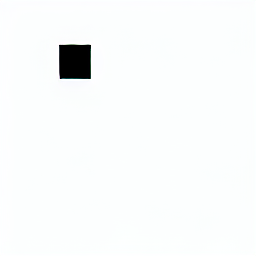


   Generating image 2/5 for prompt: "ارسم دائرة في الموقع 200 , 30"
      Using fixed seed: 43


  0%|          | 0/30 [00:00<?, ?it/s]

      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_1_ارسم دائرة في الموقع 200 _ 30.png
      Displaying generated image in Colab output:


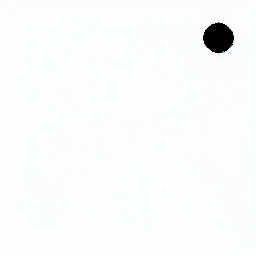


   Generating image 3/5 for prompt: "ارسم مثلث في الموقع 100 , 180"
      Using fixed seed: 44


  0%|          | 0/30 [00:00<?, ?it/s]

      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_2_ارسم مثلث في الموقع 100 _ 180.png
      Displaying generated image in Colab output:


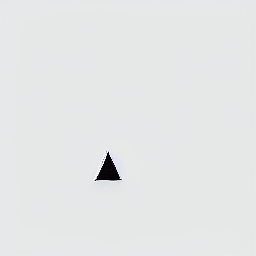


   Generating image 4/5 for prompt: "ارسم مربع في الموقع 144,194"
      Using fixed seed: 45


  0%|          | 0/30 [00:00<?, ?it/s]

      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_3_ارسم مربع في الموقع 144_194.png
      Displaying generated image in Colab output:


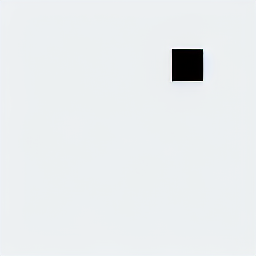


   Generating image 5/5 for prompt: "ارسم دائرة في الموقع 88,142"
      Using fixed seed: 46


  0%|          | 0/30 [00:00<?, ?it/s]

      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_4_ارسم دائرة في الموقع 88_142.png
      Displaying generated image in Colab output:


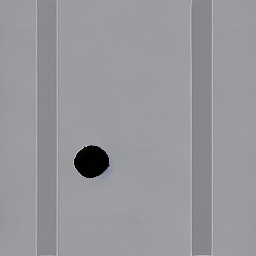

In [ ]:
#الخلية7
#تأكد أنك قد شغلت الخلايا 0، 2، و 4 بنجاح في هذه الجلسة (لربط Drive، تعريف المسارات والإعدادات، وتحميل النموذج الأساسي)
################################################################################
# الخلية 7: (مُعدلة لتعطيل مدقق الأمان) توليد صور باستخدام أوزان LoRA المحفوظة للتقييم
################################################################################
from diffusers import StableDiffusionPipeline
from peft import PeftModel
from IPython.display import display, Image as IPImage
import torch
import os
import random

# --- إعدادات التوليد (يمكنك تعديل هذه القيم) ---
LORA_EPOCH_TO_LOAD_FOR_GENERATION = None # أو حدد رقم دورة معين
YOUR_PROMPTS_FOR_GENERATION = [
    "ارسم مربع في الموقع 50 , 50",
    "ارسم دائرة في الموقع 200 , 30",
    "ارسم مثلث في الموقع 100 , 180",
    f"ارسم مربع في الموقع {random.randint(20,200)},{random.randint(20,200)}",
    f"ارسم دائرة في الموقع {random.randint(20,200)},{random.randint(20,200)}",
]
NUM_INFERENCE_STEPS_GEN = 30
GUIDANCE_SCALE_GEN = 7.5
USE_FIXED_SEED = True
SEED_VALUE = 42
# ---------------------------------------------------------------------------
# بداية الكود الفعلي للتوليد
# ---------------------------------------------------------------------------
if 'LORA_OUTPUT_DIR_NEW' not in globals() or \
   'LOCAL_SD_MODEL_PATH' not in globals() or \
   'DEVICE' not in globals() or \
   'IMAGE_SIZE' not in globals():
    print("❌ CRITICAL ERROR: Essential variables are not defined. Run Cell 2 first.")
else:
    if LORA_EPOCH_TO_LOAD_FOR_GENERATION is None:
        if os.path.exists(LORA_OUTPUT_DIR_NEW) and os.listdir(LORA_OUTPUT_DIR_NEW):
            epoch_folders_gen = [d for d in os.listdir(LORA_OUTPUT_DIR_NEW) if d.startswith("epoch_") and os.path.isdir(os.path.join(LORA_OUTPUT_DIR_NEW, d))]
            if epoch_folders_gen:
                epochs_numbers_gen = []
                for folder_name in epoch_folders_gen:
                    try: epochs_numbers_gen.append(int(folder_name.split("_")[1]))
                    except ValueError: continue
                if epochs_numbers_gen:
                    LORA_EPOCH_TO_LOAD_FOR_GENERATION = max(epochs_numbers_gen)
                    print(f"ℹ️ Automatically selected latest saved epoch: {LORA_EPOCH_TO_LOAD_FOR_GENERATION}")
                else: print(f"ℹ️ No valid epoch folders found in {LORA_OUTPUT_DIR_NEW} to automatically select from.")
            else: print(f"ℹ️ No epoch folders found in {LORA_OUTPUT_DIR_NEW} to automatically select from.")
        else: print(f"ℹ️ LoRA output directory {LORA_OUTPUT_DIR_NEW} does not exist or is empty.")

    if LORA_EPOCH_TO_LOAD_FOR_GENERATION is not None:
        lora_weights_path_for_generation = os.path.join(LORA_OUTPUT_DIR_NEW, f"epoch_{LORA_EPOCH_TO_LOAD_FOR_GENERATION}")
        print(f"🧪 Attempting to generate images using LoRA weights from: {lora_weights_path_for_generation}")
        adapter_bin_file = os.path.join(lora_weights_path_for_generation, "adapter_model.bin")
        adapter_safetensors_file = os.path.join(lora_weights_path_for_generation, "adapter_model.safetensors")

        if os.path.exists(lora_weights_path_for_generation) and \
           (os.path.exists(adapter_bin_file) or os.path.exists(adapter_safetensors_file)):
            try:
                print(f"Loading base Stable Diffusion model from: {LOCAL_SD_MODEL_PATH}...")
                pipe_for_generation = StableDiffusionPipeline.from_pretrained(LOCAL_SD_MODEL_PATH, torch_dtype=torch.float16)

                print(f"Loading LoRA weights from: {lora_weights_path_for_generation} and applying to UNet...")
                pipe_for_generation.unet = PeftModel.from_pretrained(pipe_for_generation.unet, lora_weights_path_for_generation)

                # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
                # <<<<<<< أضف هذا السطر لتعطيل مدقق الأمان >>>>>>>
                pipe_for_generation.safety_checker = None
                # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

                pipe_for_generation.to(DEVICE)
                print(f"✅ Successfully loaded base model and applied LoRA weights (epoch {LORA_EPOCH_TO_LOAD_FOR_GENERATION}). Model is on {DEVICE}. Safety checker disabled.")

                generated_samples_output_dir = os.path.join(LORA_OUTPUT_DIR_NEW, f"generated_samples_epoch_{LORA_EPOCH_TO_LOAD_FOR_GENERATION}")
                os.makedirs(generated_samples_output_dir, exist_ok=True)
                print(f"Generated images will be saved to: {generated_samples_output_dir}")

                for i, prompt_text in enumerate(YOUR_PROMPTS_FOR_GENERATION):
                    print(f"\n   Generating image {i+1}/{len(YOUR_PROMPTS_FOR_GENERATION)} for prompt: \"{prompt_text}\"")
                    generator = None
                    if USE_FIXED_SEED:
                        generator = torch.Generator(device=DEVICE).manual_seed(SEED_VALUE + i)
                        print(f"      Using fixed seed: {SEED_VALUE + i}")
                    with torch.no_grad():
                        generated_image = pipe_for_generation(
                            prompt_text, num_inference_steps=NUM_INFERENCE_STEPS_GEN,
                            guidance_scale=GUIDANCE_SCALE_GEN, height=IMAGE_SIZE[0],
                            width=IMAGE_SIZE[1], generator=generator
                        ).images[0] # pipeline يعيد قائمة صور، نأخذ الأولى

                    # لا يوجد فحص NSFW هنا لأننا عطلنا الـ safety_checker
                    # generated_image الآن يجب أن تكون الصورة الفعلية المولدة

                    safe_prompt_filename = "".join(c if c.isalnum() or c in " _-" else "_" for c in prompt_text[:50])
                    image_filename = f"generated_sample_{i}_{safe_prompt_filename}.png"
                    image_save_path = os.path.join(generated_samples_output_dir, image_filename)
                    generated_image.save(image_save_path)
                    print(f"      Image saved to: {image_save_path}")
                    print("      Displaying generated image in Colab output:")
                    display(generated_image)
            except Exception as e:
                print(f"❌ An error occurred during image generation: {e}")
                import traceback
                traceback.print_exc()
        else:
            print(f"⚠️ LoRA weights path exists ({lora_weights_path_for_generation}), but adapter_model file (bin or safetensors) not found inside.")
    else:
        print("ℹ️ No valid LORA_EPOCH_TO_LOAD_FOR_GENERATION was set or found. Skipping image generation.")

ℹ️ Automatically selected latest saved epoch: 11
🧪 Attempting to generate images using LoRA weights from: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/epoch_11
Loading base Stable Diffusion model from: /content/drive/MyDrive/NewProject/stable_diffusion_lora/stable-diffusion-v1-4...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading LoRA weights from: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/epoch_11 and applying to UNet...
✅ Successfully loaded base model and applied LoRA weights (epoch 11). Model is on cuda. Safety checker disabled.
Generated images will be saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11

   Generating image 1/17 for prompt: "ارسم مربع في الموقع 10 , 10"
      Using fixed seed: 42


  0%|          | 0/30 [00:00<?, ?it/s]

      Reference point (target) drawn at (10, 10) for comparison.
      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_0_ارسم مربع في الموقع 10 _ 10_seed42.png
      Displaying generated image in Colab output:


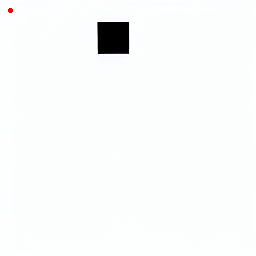


   Generating image 2/17 for prompt: "ارسم دائرة في الموقع 230 , 15"
      Using fixed seed: 43


  0%|          | 0/30 [00:00<?, ?it/s]

      Reference point (target) drawn at (230, 15) for comparison.
      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_1_ارسم دائرة في الموقع 230 _ 15_seed43.png
      Displaying generated image in Colab output:


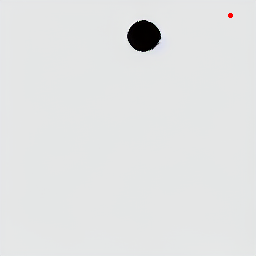


   Generating image 3/17 for prompt: "ارسم مثلث في الموقع 20 , 220"
      Using fixed seed: 44


  0%|          | 0/30 [00:00<?, ?it/s]

      Reference point (target) drawn at (20, 220) for comparison.
      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_2_ارسم مثلث في الموقع 20 _ 220_seed44.png
      Displaying generated image in Colab output:


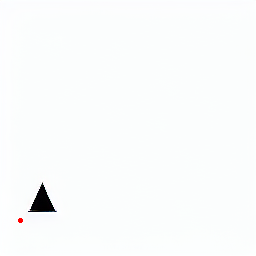


   Generating image 4/17 for prompt: "ارسم مربع في الموقع 225 , 225"
      Using fixed seed: 45


  0%|          | 0/30 [00:00<?, ?it/s]

      Reference point (target) drawn at (225, 225) for comparison.
      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_3_ارسم مربع في الموقع 225 _ 225_seed45.png
      Displaying generated image in Colab output:


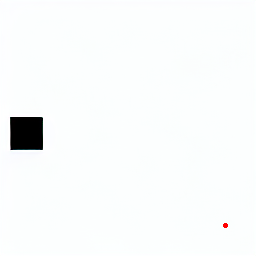


   Generating image 5/17 for prompt: "ارسم دائرة في الموقع 128 , 128"
      Using fixed seed: 46


  0%|          | 0/30 [00:00<?, ?it/s]

      Reference point (target) drawn at (128, 128) for comparison.
      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_4_ارسم دائرة في الموقع 128 _ 128_seed46.png
      Displaying generated image in Colab output:


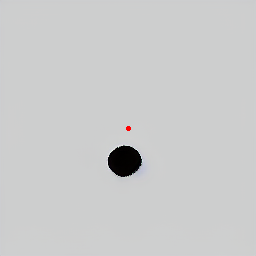


   Generating image 6/17 for prompt: "ارسم مثلث في الموقع 128 , 50"
      Using fixed seed: 47


  0%|          | 0/30 [00:00<?, ?it/s]

      Reference point (target) drawn at (128, 50) for comparison.
      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_5_ارسم مثلث في الموقع 128 _ 50_seed47.png
      Displaying generated image in Colab output:


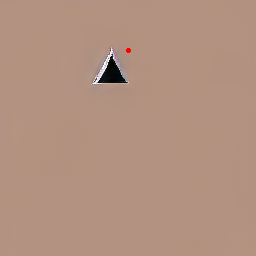


   Generating image 7/17 for prompt: "ارسم مربع في الموقع 75 , 90"
      Using fixed seed: 48


  0%|          | 0/30 [00:00<?, ?it/s]

      Reference point (target) drawn at (75, 90) for comparison.
      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_6_ارسم مربع في الموقع 75 _ 90_seed48.png
      Displaying generated image in Colab output:


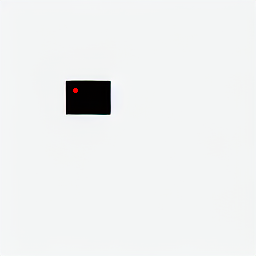


   Generating image 8/17 for prompt: "ارسم دائرة في الموقع 150 , 160"
      Using fixed seed: 49


  0%|          | 0/30 [00:00<?, ?it/s]

      Reference point (target) drawn at (150, 160) for comparison.
      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_7_ارسم دائرة في الموقع 150 _ 160_seed49.png
      Displaying generated image in Colab output:


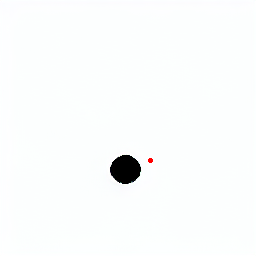


   Generating image 9/17 for prompt: "ارسم مثلث في الموقع 49,133"
      Using fixed seed: 50


  0%|          | 0/30 [00:00<?, ?it/s]

      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_8_ارسم مثلث في الموقع 49_133_seed50.png
      Displaying generated image in Colab output:


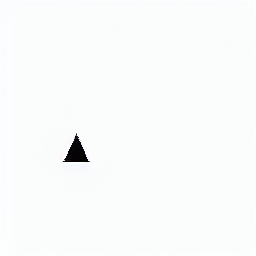


   Generating image 10/17 for prompt: "ارسم مربع في الموقع 81,142"
      Using fixed seed: 51


  0%|          | 0/30 [00:00<?, ?it/s]

      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_9_ارسم مربع في الموقع 81_142_seed51.png
      Displaying generated image in Colab output:


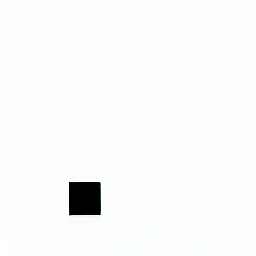


   Generating image 11/17 for prompt: "ارسم دائرة في الموقع 25,136"
      Using fixed seed: 52


  0%|          | 0/30 [00:00<?, ?it/s]

      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_10_ارسم دائرة في الموقع 25_136_seed52.png
      Displaying generated image in Colab output:


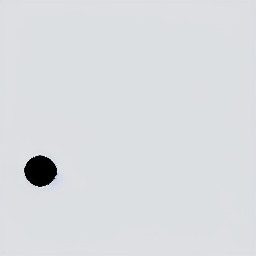


   Generating image 12/17 for prompt: "ارسم مربع في اعلى يسار الصورة"
      Using fixed seed: 53


  0%|          | 0/30 [00:00<?, ?it/s]

      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_11_ارسم مربع في اعلى يسار الصورة_seed53.png
      Displaying generated image in Colab output:


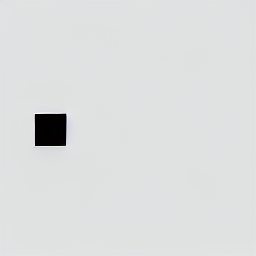


   Generating image 13/17 for prompt: "ارسم دائرة في منتصف الصورة تماما"
      Using fixed seed: 54


  0%|          | 0/30 [00:00<?, ?it/s]

      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_12_ارسم دائرة في منتصف الصورة تماما_seed54.png
      Displaying generated image in Colab output:


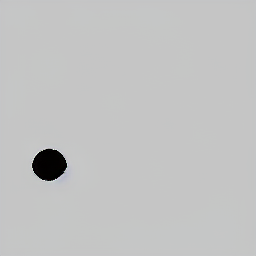


   Generating image 14/17 for prompt: "ارسم مثلث في الركن السفلي الايمن"
      Using fixed seed: 55


  0%|          | 0/30 [00:00<?, ?it/s]

      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_13_ارسم مثلث في الركن السفلي الايمن_seed55.png
      Displaying generated image in Colab output:


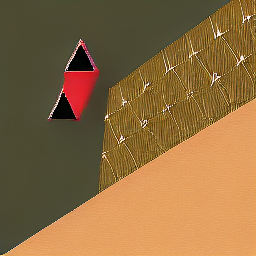


   Generating image 15/17 for prompt: "ارسم مربع كبير في الموقع 100 , 100"
      Using fixed seed: 56


  0%|          | 0/30 [00:00<?, ?it/s]

      Reference point (target) drawn at (100, 100) for comparison.
      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_14_ارسم مربع كبير في الموقع 100 _ 100_seed56.png
      Displaying generated image in Colab output:


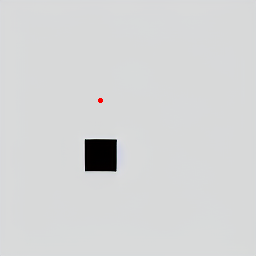


   Generating image 16/17 for prompt: "ارسم دائرة صغيرة في الموقع 30 , 30"
      Using fixed seed: 57


  0%|          | 0/30 [00:00<?, ?it/s]

      Reference point (target) drawn at (30, 30) for comparison.
      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_15_ارسم دائرة صغيرة في الموقع 30 _ 30_seed57.png
      Displaying generated image in Colab output:


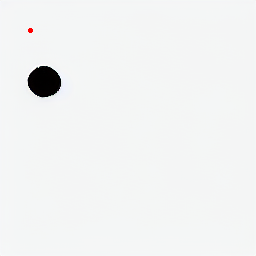


   Generating image 17/17 for prompt: "ارسم شكل هندسي في الموقع 120 , 120"
      Using fixed seed: 58


  0%|          | 0/30 [00:00<?, ?it/s]

      Reference point (target) drawn at (120, 120) for comparison.
      Image saved to: /content/drive/MyDrive/project_computer_drawing_v6_3k/lora_outputs_current_3k/generated_samples_epoch_11/generated_sample_16_ارسم شكل هندسي في الموقع 120 _ 120_seed58.png
      Displaying generated image in Colab output:


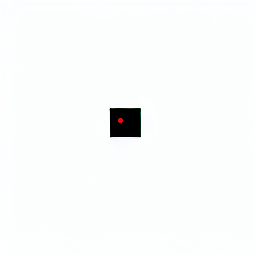

In [ ]:
#الخلية8
################################################################################
# الخلية 7: (مُعدلة ومرنة - مع مجموعة متنوعة من الأوامر) توليد صور باستخدام أوزان LoRA المحفوظة للتقييم
################################################################################
from diffusers import StableDiffusionPipeline
from peft import PeftModel
from IPython.display import display, Image as IPImage
import torch
import os
import random

# --- إعدادات التوليد (يمكنك تعديل هذه القيم) ---

# 1. حدد رقم الدورة (Epoch) التي تريد استخدام أوزان LoRA منها.
#    إذا تركتها None، سيحاول الكود العثور على أحدث دورة محفوظة.
#    مثال: LORA_EPOCH_TO_LOAD_FOR_GENERATION = 11 (لاستخدام أوزان الدورة 11)
LORA_EPOCH_TO_LOAD_FOR_GENERATION = None # None يعني البحث عن الأحدث تلقائيًا

# 2. الأوامر النصية التي تريد توليد صور لها.
YOUR_PROMPTS_FOR_GENERATION = [
    # أوامر مباشرة لاختبار الدقة الأساسية
    "ارسم مربع في الموقع 10 , 10",
    "ارسم دائرة في الموقع 230 , 15",
    "ارسم مثلث في الموقع 20 , 220",
    "ارسم مربع في الموقع 225 , 225",
    "ارسم دائرة في الموقع 128 , 128", # مركز الصورة
    "ارسم مثلث في الموقع 128 , 50",  # أعلى المنتصف
    "ارسم مربع في الموقع 75 , 90",
    "ارسم دائرة في الموقع 150 , 160",
    # أوامر عشوائية لاختبار المرونة
    f"ارسم مثلث في الموقع {random.randint(20,200)},{random.randint(20,200)}",
    f"ارسم مربع في الموقع {random.randint(20,200)},{random.randint(20,200)}",
    f"ارسم دائرة في الموقع {random.randint(20,200)},{random.randint(20,200)}",
    # أوامر مع محاولة وصف الموقع بشكل مختلف (لاختبار الفهم)
    "ارسم مربع في اعلى يسار الصورة",
    "ارسم دائرة في منتصف الصورة تماما",
    "ارسم مثلث في الركن السفلي الايمن",
    # أوامر مع محاولة وصف الحجم (لاختبار قدرة التعميم)
    "ارسم مربع كبير في الموقع 100 , 100",
    "ارسم دائرة صغيرة في الموقع 30 , 30",
    # أوامر قد تكون مربكة (لاختبار الحدود)
    "ارسم شكل هندسي في الموقع 120 , 120",
    # "ارسم مربع ودائرة في الموقع 70 , 70" # هذا قد يكون معقدًا جدًا حاليًا
]

# 3. معاملات التوليد (يمكنك تجربتها)
NUM_INFERENCE_STEPS_GEN = 30
GUIDANCE_SCALE_GEN = 7.5
USE_FIXED_SEED = True
SEED_VALUE = 42 # يمكنك تغيير هذه القيمة للحصول على تنوع إذا كانت USE_FIXED_SEED هي True
# ---------------------------------------------------------------------------
# بداية الكود الفعلي للتوليد
# ---------------------------------------------------------------------------

if 'LORA_OUTPUT_DIR_NEW' not in globals() or \
   'LOCAL_SD_MODEL_PATH' not in globals() or \
   'DEVICE' not in globals() or \
   'IMAGE_SIZE' not in globals():
    print("❌ CRITICAL ERROR: Essential variables (LORA_OUTPUT_DIR_NEW, LOCAL_SD_MODEL_PATH, DEVICE, IMAGE_SIZE) are not defined.")
    print("   Please ensure you have run Cell 2 successfully in this session.")
    # exit()
else:
    if LORA_EPOCH_TO_LOAD_FOR_GENERATION is None:
        if os.path.exists(LORA_OUTPUT_DIR_NEW) and os.listdir(LORA_OUTPUT_DIR_NEW):
            epoch_folders_gen = [d for d in os.listdir(LORA_OUTPUT_DIR_NEW) if d.startswith("epoch_") and os.path.isdir(os.path.join(LORA_OUTPUT_DIR_NEW, d))]
            if epoch_folders_gen:
                epochs_numbers_gen = []
                for folder_name in epoch_folders_gen:
                    try: epochs_numbers_gen.append(int(folder_name.split("_")[1]))
                    except ValueError: continue
                if epochs_numbers_gen:
                    LORA_EPOCH_TO_LOAD_FOR_GENERATION = max(epochs_numbers_gen)
                    print(f"ℹ️ Automatically selected latest saved epoch: {LORA_EPOCH_TO_LOAD_FOR_GENERATION}")
                else: print(f"ℹ️ No valid epoch folders found in {LORA_OUTPUT_DIR_NEW} to automatically select from.")
            else: print(f"ℹ️ No epoch folders found in {LORA_OUTPUT_DIR_NEW} to automatically select from.")
        else: print(f"ℹ️ LoRA output directory {LORA_OUTPUT_DIR_NEW} does not exist or is empty.")

    if LORA_EPOCH_TO_LOAD_FOR_GENERATION is not None:
        lora_weights_path_for_generation = os.path.join(LORA_OUTPUT_DIR_NEW, f"epoch_{LORA_EPOCH_TO_LOAD_FOR_GENERATION}")
        print(f"🧪 Attempting to generate images using LoRA weights from: {lora_weights_path_for_generation}")
        adapter_bin_file = os.path.join(lora_weights_path_for_generation, "adapter_model.bin")
        adapter_safetensors_file = os.path.join(lora_weights_path_for_generation, "adapter_model.safetensors")

        if os.path.exists(lora_weights_path_for_generation) and \
           (os.path.exists(adapter_bin_file) or os.path.exists(adapter_safetensors_file)):
            try:
                print(f"Loading base Stable Diffusion model from: {LOCAL_SD_MODEL_PATH}...")
                pipe_for_generation = StableDiffusionPipeline.from_pretrained(LOCAL_SD_MODEL_PATH, torch_dtype=torch.float16)

                print(f"Loading LoRA weights from: {lora_weights_path_for_generation} and applying to UNet...")
                pipe_for_generation.unet = PeftModel.from_pretrained(pipe_for_generation.unet, lora_weights_path_for_generation)

                pipe_for_generation.safety_checker = None # تعطيل مدقق الأمان

                pipe_for_generation.to(DEVICE)
                print(f"✅ Successfully loaded base model and applied LoRA weights (epoch {LORA_EPOCH_TO_LOAD_FOR_GENERATION}). Model is on {DEVICE}. Safety checker disabled.")

                generated_samples_output_dir = os.path.join(LORA_OUTPUT_DIR_NEW, f"generated_samples_epoch_{LORA_EPOCH_TO_LOAD_FOR_GENERATION}")
                os.makedirs(generated_samples_output_dir, exist_ok=True)
                print(f"Generated images will be saved to: {generated_samples_output_dir}")

                for i, prompt_text in enumerate(YOUR_PROMPTS_FOR_GENERATION):
                    print(f"\n   Generating image {i+1}/{len(YOUR_PROMPTS_FOR_GENERATION)} for prompt: \"{prompt_text}\"")
                    generator = None
                    current_seed = SEED_VALUE + i # بذرة مختلفة قليلاً لكل صورة إذا كانت البذرة ثابتة
                    if USE_FIXED_SEED:
                        generator = torch.Generator(device=DEVICE).manual_seed(current_seed)
                        print(f"      Using fixed seed: {current_seed}")

                    # محاولة استخراج الإحداثيات لرسم النقطة المرجعية
                    target_x_ref, target_y_ref = None, None
                    try:
                        if "الموقع " in prompt_text:
                            coord_part = prompt_text.split("الموقع ")[1]
                            if " , " in coord_part:
                                x_str, y_str_remaining = coord_part.split(" , ", 1)
                                # أخذ الأرقام فقط من y_str_remaining
                                y_str = "".join(filter(str.isdigit, y_str_remaining.split(" ")[0]))
                                if x_str.strip().isdigit() and y_str.strip().isdigit():
                                    target_x_ref = int(x_str.strip())
                                    target_y_ref = int(y_str.strip())
                    except Exception:
                        pass # تجاهل الخطأ إذا لم يتمكن من تحليل الإحداثيات

                    with torch.no_grad():
                        generated_image_pil = pipe_for_generation(
                            prompt_text, num_inference_steps=NUM_INFERENCE_STEPS_GEN,
                            guidance_scale=GUIDANCE_SCALE_GEN, height=IMAGE_SIZE[0],
                            width=IMAGE_SIZE[1], generator=generator
                        ).images[0]

                    image_to_display_and_save = generated_image_pil.copy() # اعمل نسخة للرسم عليها

                    # رسم النقطة المرجعية إذا تم استخراج الإحداثيات
                    if target_x_ref is not None and target_y_ref is not None:
                        try:
                            draw_ref = ImageDraw.Draw(image_to_display_and_save)
                            radius_ref = 2
                            draw_ref.ellipse(
                                (target_x_ref - radius_ref, target_y_ref - radius_ref, target_x_ref + radius_ref, target_y_ref + radius_ref),
                                fill="red", outline="red"
                            )
                            print(f"      Reference point (target) drawn at ({target_x_ref}, {target_y_ref}) for comparison.")
                        except Exception as e_draw_ref:
                            print(f"      Could not draw reference point: {e_draw_ref}")

                    safe_prompt_filename = "".join(c if c.isalnum() or c in " _-" else "_" for c in prompt_text[:50])
                    image_filename = f"generated_sample_{i}_{safe_prompt_filename}_seed{current_seed if USE_FIXED_SEED else 'rand'}.png"
                    image_save_path = os.path.join(generated_samples_output_dir, image_filename)

                    image_to_display_and_save.save(image_save_path) # حفظ الصورة مع النقطة المرجعية (إذا وجدت)
                    print(f"      Image saved to: {image_save_path}")

                    print("      Displaying generated image in Colab output:")
                    display(image_to_display_and_save)
            except Exception as e:
                print(f"❌ An error occurred during image generation: {e}")
                import traceback
                traceback.print_exc()
        else:
            print(f"⚠️ LoRA weights path exists ({lora_weights_path_for_generation}), but adapter_model file (bin or safetensors) not found inside.")
    else:
        print("ℹ️ No valid LORA_EPOCH_TO_LOAD_FOR_GENERATION was set or found. Skipping image generation.")

In [ ]:
#الخلية9
#عتعديل  مقترح للخلية 9 لتكون خلية توليد مستقلة (بعد تشغيل 0، 2، 4):
################################################################################
# الخلية 9 (أو خلية جديدة): توليد صور باستخدام نموذج LoRA المدرب
################################################################################
from diffusers import StableDiffusionPipeline
from peft import PeftModel
from IPython.display import display
import torch
import os
import random # إذا كنت ستستخدم أوامر عشوائية

# تأكد أن هذه المتغيرات معرفة من الخلية 2 و 4
# LOCAL_SD_MODEL_PATH (من الخلية 2)
# LORA_OUTPUT_DIR_NEW (من الخلية 2)
# DEVICE (من الخلية 2، يجب أن يكون cuda)
# IMAGE_SIZE (من الخلية 2)
# unet (من الخلية 4، النموذج الأساسي قبل تطبيق LoRA) - سنحتاج لتحميله إذا لم يكن Pipeline يوفره

# --- إعدادات التوليد ---
# حدد رقم الدورة التي تريد استخدام أوزانها، أو ابحث عن أحدث دورة محفوظة
LORA_EPOCH_TO_LOAD_FOR_GENERATION = 11 # <<<<<< غير هذا الرقم إلى الدورة التي تريد استخدامها (مثلاً، أفضل دورة لديك)
# أو اترك الكود يبحث عن أحدث دورة إذا كنت تريد ذلك:
# LORA_EPOCH_TO_LOAD_FOR_GENERATION = None
# if LORA_EPOCH_TO_LOAD_FOR_GENERATION is None and os.path.exists(LORA_OUTPUT_DIR_NEW) and os.listdir(LORA_OUTPUT_DIR_NEW):
#     epoch_folders_gen = [d for d in os.listdir(LORA_OUTPUT_DIR_NEW) if d.startswith("epoch_") and os.path.isdir(os.path.join(LORA_OUTPUT_DIR_NEW, d))]
#     if epoch_folders_gen:
#         epochs_numbers_gen = [int(f.split("_")[1]) for f in epoch_folders_gen if f.split("_")[1].isdigit()]
#         if epochs_numbers_gen: LORA_EPOCH_TO_LOAD_FOR_GENERATION = max(epochs_numbers_gen)

if LORA_EPOCH_TO_LOAD_FOR_GENERATION is not None:
    lora_weights_path = os.path.join(LORA_OUTPUT_DIR_NEW, f"epoch_{LORA_EPOCH_TO_LOAD_FOR_GENERATION}")
    print(f"🧪 Attempting to generate images using LoRA weights from: {lora_weights_path}")

    adapter_bin_file = os.path.join(lora_weights_path, "adapter_model.bin")
    adapter_safetensors_file = os.path.join(lora_weights_path, "adapter_model.safetensors")

    if os.path.exists(lora_weights_path) and (os.path.exists(adapter_bin_file) or os.path.exists(adapter_safetensors_file)):
        try:
            # 1. تحميل النموذج الأساسي (Pipeline)
            # (نفترض أن LOCAL_SD_MODEL_PATH و DEVICE معرفان من الخلية 2)
            pipe_for_generation = StableDiffusionPipeline.from_pretrained(LOCAL_SD_MODEL_PATH, torch_dtype=torch.float16)

            # 2. تحميل وتطبيق أوزان LoRA على UNet الخاص بالـ pipeline
            # PeftModel.from_pretrained يتوقع النموذج الأساسي الذي سيتم تطبيق LoRA عليه
            pipe_for_generation.unet = PeftModel.from_pretrained(pipe_for_generation.unet, lora_weights_path)

            pipe_for_generation.to(DEVICE)
            print(f"✅ Loaded base model and applied LoRA weights from epoch {LORA_EPOCH_TO_LOAD_FOR_GENERATION}.")

            # 3. الأوامر النصية التي تريد توليد صور لها
            your_prompts = [
                "ارسم مربع في الموقع 30 , 70",
                "ارسم دائرة في الموقع 180 , 120",
                "ارسم مثلث احمر كبير في الموقع 90 , 90", # جرب إضافة تفاصيل (قد لا تعمل إذا لم يتم التدريب عليها)
                "ارسم مربع ازرق صغير", # مثال على أمر مختلف
                # أضف المزيد من الأوامر هنا
            ]

            output_generation_folder = os.path.join(LORA_OUTPUT_DIR_NEW, f"generated_images_with_epoch_{LORA_EPOCH_TO_LOAD_FOR_GENERATION}")
            os.makedirs(output_generation_folder, exist_ok=True)

            num_inference_steps_gen = 30
            guidance_scale_gen = 7.5

            for i, prompt in enumerate(your_prompts):
                print(f"   Generating image for: \"{prompt}\"")
                # قد تحتاج لاستخدام torch.Generator للتحكم في البذور (seeds) إذا أردت نتائج قابلة للتكرار
                # generator = torch.Generator(device=DEVICE).manual_seed(42 + i) # مثال
                with torch.no_grad():
                    image = pipe_for_generation(
                        prompt,
                        num_inference_steps=num_inference_steps_gen,
                        guidance_scale=guidance_scale_gen,
                        height=IMAGE_SIZE[0], # IMAGE_SIZE من الخلية 2
                        width=IMAGE_SIZE[1],
                        # generator=generator # إذا استخدمت generator
                    ).images[0]

                # تعديل اسم الملف ليكون أكثر وضوحًا
                safe_prompt_filename = "".join(c if c.isalnum() or c in " _-" else "_" for c in prompt[:30]) # اجعل اسم الملف آمنًا
                image_save_path = os.path.join(output_generation_folder, f"generated_{i}_{safe_prompt_filename}.png")
                image.save(image_save_path)
                print(f"   Saved to: {image_save_path}")
                display(image) # عرض الصورة في Colab

        except Exception as e:
            print(f"❌ Error during image generation with LoRA: {e}")
            import traceback
            traceback.print_exc() # لطباعة تتبع الخطأ الكامل إذا حدث
    else:
        print(f"⚠️ LoRA weights path or adapter_model file not found: {lora_weights_path}. Cannot generate images.")
else:
    print("ℹ️ LORA_EPOCH_TO_LOAD_FOR_GENERATION is not set or no LoRA weights found in the new output directory. Skipping image generation.")